In [1]:
%load_ext autoreload
%autoreload 2
# If using Jupyter Lab, use widget instead of notebook
%pylab notebook --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

# Bigger plots
plt.rcParams['figure.figsize'] = 15, 10
# Wider maximum width of pandas columns (needed to see the full lists of molecules)
pd.set_option('max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

In [3]:
# To install dependencies: pip install metaspace2020>=1.7.2 scikit-learn scikit-image seaborn matplotlib pandas numpy pyimzml
from getpass import getpass
import json
from collections import defaultdict
from pathlib import Path
from metaspace.sm_annotation_utils import SMInstance
from sklearn.decomposition import PCA
from skimage.draw import ellipse
import seaborn as sns
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
# "definitions" is part of the metabolite_analysis repo. 
# If the following line doesn't work, check you're in the 
# right conda environment and `pip install -e .` in the 
# metabolite_analysis directory
from definitions import ROOT_DIR 

In [ ]:
## Utility functions

In [4]:
def make_transform(from_, to):
    """ 
    Estimate the coordinate-space transform to map coordinates in `from_` to the values in `to`.
    Returns a function to convert from `from_`-space to `to`-space
    """
    from_padded = [(*c, 1) for c in from_]
    to_padded = [(*c, 1) for c in to]
    res = np.linalg.lstsq(from_padded, to_padded, rcond=None)
    mat = res[0]

    def transform(*x):
        if len(x) == 1 and isinstance(x[0], tuple):
            x = x[0]
        return np.dot([*x, 1], mat)[:-1]

    return transform


def make_mask(h, w, positions, grid_coords, n_rows, n_cols, spot_h, spot_w, alternating_rows):
    """
    Calculates a mask where each pixel value indicates which spot it's in, with `0` meaning 'background'.
    Returns the 2d mask, and a list mapping values to spot names (e.g. '0_1' for row 0 column 1).
    """
    cell_to_position = make_transform(grid_coords, positions)
    rx, ry = spot_h / 2, spot_w / 2
    mask = np.zeros((h, w), np.int32)
    mask_names = ['background']
    
    i = 1
    for y in range(n_rows):
        odd = alternating_rows and y % 2 == 1
        xs = range(n_cols - 1 if odd else n_cols) # Use 1 fewer column on odd rows
        for x in xs:
            yc, xc = cell_to_position(y, x + 0.5 if odd else x)
            # Snap the calculated coordinates to the pixel grid so that generated ellipses have the same shape
            yc = round(yc) + 0.5 - ry % 1
            xc = round(xc) + 0.5 - rx % 1
            xx, yy = ellipse(yc, xc, ry, rx, (h, w))
            mask[xx, yy] = i
            mask_names.append(f'{y}_{x}')
            i += 1
    return mask, mask_names


def colorize_mask(mask):
    """
    Converts each mask value to a color, with background values being fully transparent. 
    For visualization only.
    """
    cnt = np.max(mask)
    print(cnt)
    palette = [
        (0,0,0,0),
        *[(r,g,b,0.5) for r,g,b in sns.color_palette('hls', int(cnt))]
    ]
    image = np.empty((*mask.shape, 4))
    print(image.shape)
    for (y, x), val in np.ndenumerate(mask):
        image[y, x, :] = palette[val]
    return image
    

# Log in to METASPACE

**Hidden feature:** If you make a file containing your API key, `SMInstance` will automatically log in and you won't need to enter your API key every time.

You can create this file with:

```python
from pathlib import Path
Path('~/.metaspace').open('w').write('api_key=XXXXXX' + '\n')
```

*(replace the XXXXXX with you actual API key)*

In [5]:
sm = SMInstance()
if not sm.logged_in():
    print('Enter your API key from https://metaspace2020.eu/user/me')
    sm.login(api_key=getpass())
else:
    print('Already logged in')

Enter your API key from https://metaspace2020.eu/user/me
········


# Select a dataset and download data

**Select a dataset and database/fdr for the images to use for alignment in the below cell**

In [6]:
dataset_id = '2020-03-12_17h55m21s'
fdr = 0.5
database = 'SwissLipids-2018-02-02' # or 'HMDB-v4'

In [7]:
# Define input/output paths
input_grid_file = Path(ROOT_DIR) / 'data' / 'input_grids' / f'{dataset_id}.json'
output_mask_file = Path(ROOT_DIR) / 'data' / 'grid_masks' / f'{dataset_id}.npy'
output_mask_names_file = Path(ROOT_DIR) / 'data' / 'grid_masks' / f'{dataset_id}_mask_names.json'

# Download annotations & images
annotations = sm.get_annotations(fdr, database, {'ids': dataset_id})
images = sm.dataset(id=dataset_id).all_annotation_images(fdr, database, True, True)
# Put images into a dictionary for easy lookup
images = dict(((img.formula, img.adduct), img[0]) for img in images)
# Get width & height
h, w = next(iter(images.values())).shape
# Create a 2D numpy array where each row is a linearized 1D image, 
# for easy simultaneous manipulation of all images
images_flat = np.array(list(images.values())).reshape(len(images), -1)

c:\users\ekelof\appdata\local\programs\python\python38-32\lib\site-packages\metaspace\sm_annotation_utils.py:972: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = pd.io.json.json_normalize(records)


# Find a good image to help with alignment

<IPython.core.display.Javascript object>


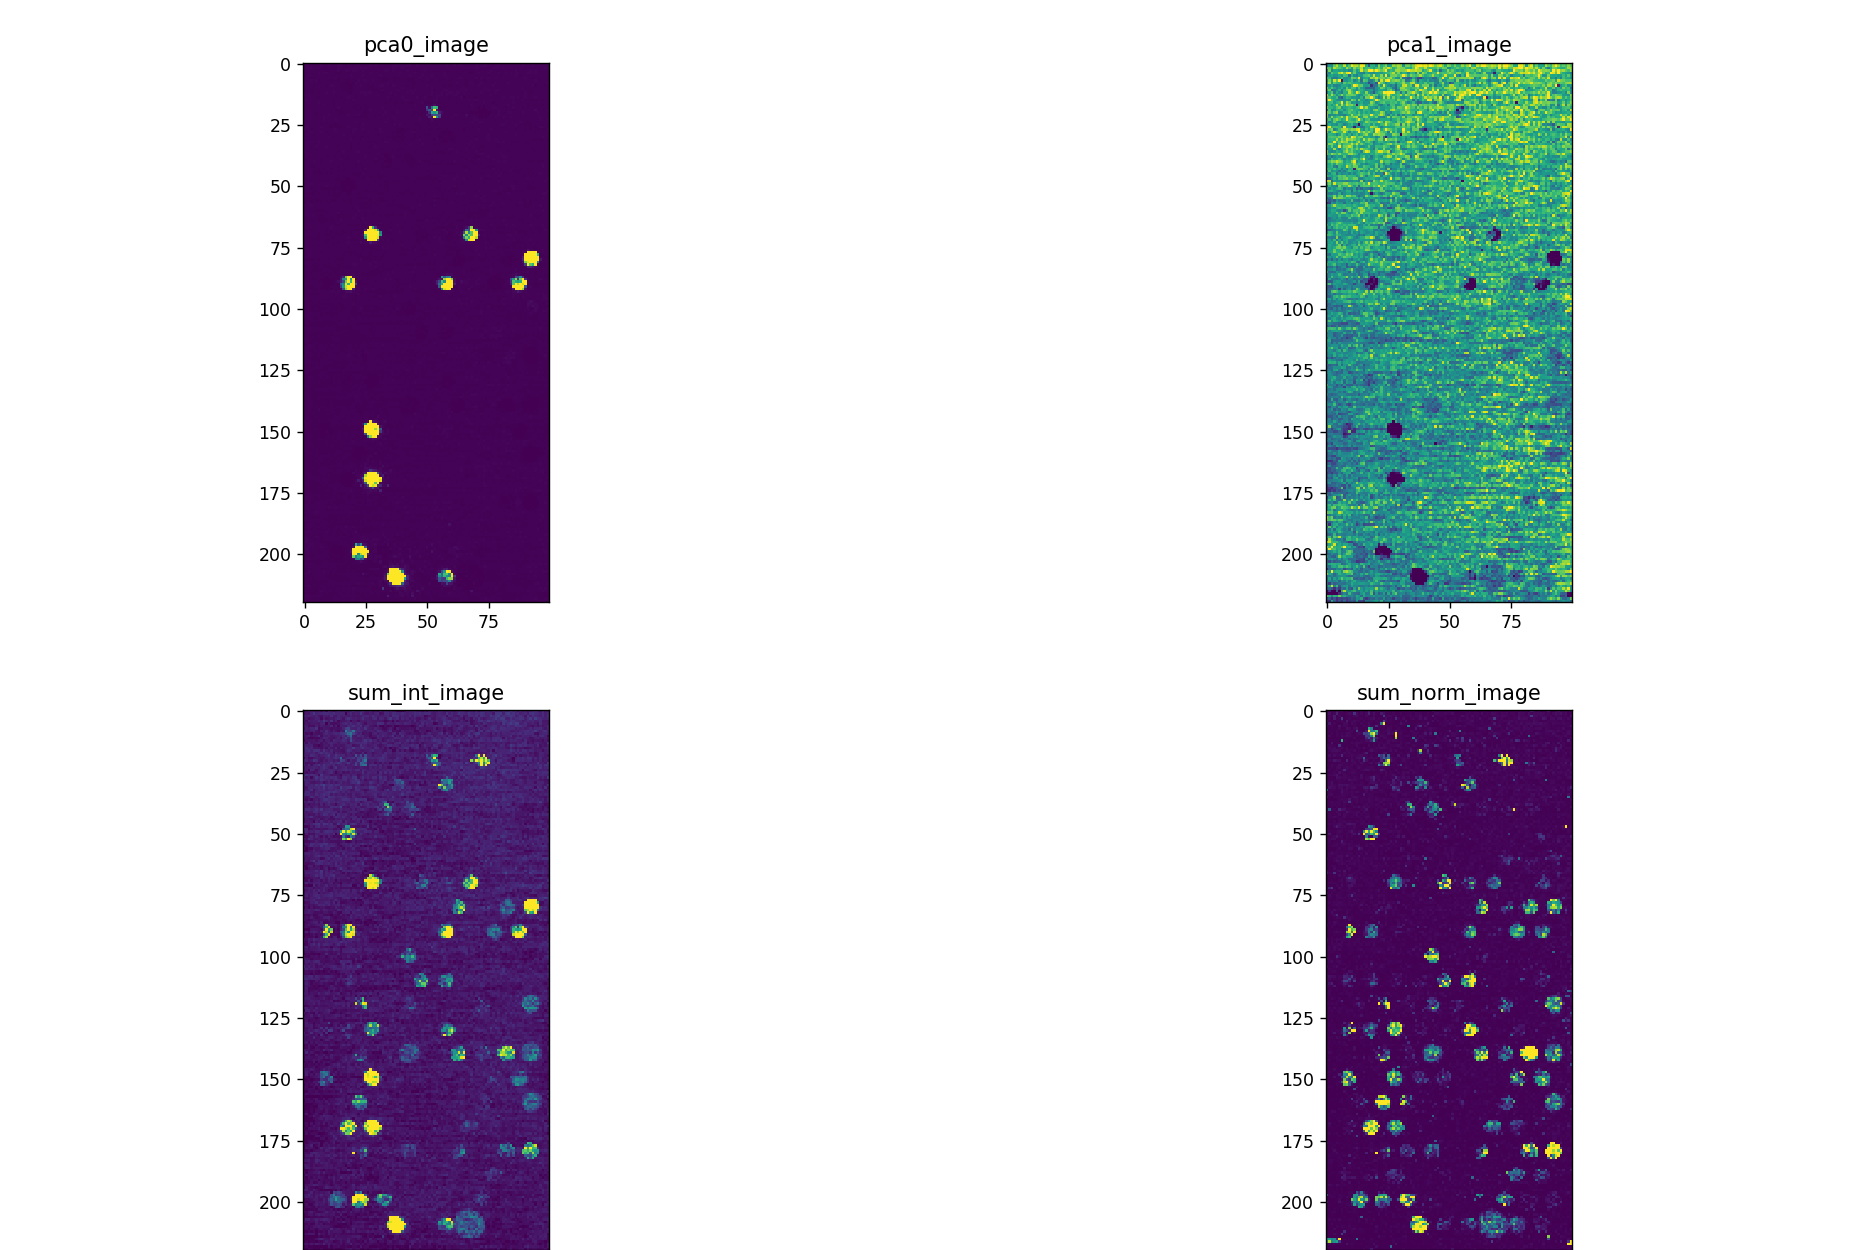

In [8]:
# Individual ion images usually aren't great for alignment.
# This just calculates 4 types of summary images - usually one or two will
# clearly show a wide selection of spots, which helps a lot.
pca = PCA(2, whiten=True)
pca.fit(images_flat)

def prep_image(flat_image):
    img = np.clip(flat_image, np.percentile(flat_image, 1), np.percentile(flat_image, 99)).reshape(h, w)
    img -= np.min(img)
    return img

pca0_image = prep_image(pca.components_[0])
pca1_image = prep_image(pca.components_[1])
sum_int_image = prep_image(np.sum(images_flat, axis=0))
sum_norm_image = prep_image(np.sum(images_flat / np.sum(images_flat, axis=1, keepdims=True), axis=0))
plt.close('all')
plt.subplot(2,2,1, title='pca0_image')
plt.imshow(pca0_image)
plt.subplot(2,2,2, title='pca1_image')
plt.imshow(pca1_image)
plt.subplot(2,2,3, title='sum_int_image')
plt.imshow(sum_int_image)
plt.subplot(2,2,4, title='sum_norm_image')
plt.imshow(sum_norm_image)
plt.autoscale(tight=True)
plt.subplots_adjust(left=0, right=1, top=0.95, bottom=0)
plt.show()

**Uncomment the line for one of the above guide images to be used for alignment**

In [9]:
# example_image = pca0_image
# example_image = pca1_image
# example_image = sum_int_image
example_image = sum_norm_image

# Create grid calibration file (if it doesn't already exist)

In [ ]:
# This writes a template JSON file as a starting point for alignment
# The "help:" fields aren't actually used, it's just an easy way to leave inline comments in JSON
# If the file already exists, this doesn't do anything
if not input_grid_file.exists():
    input_grid_file.parent.mkdir(parents=True, exist_ok=True)
    n_rows, n_cols = 21, 10
    input_grid_file.open('w').write(f"""
{{
    "help:general": "Keep in mind that json is a different format and much less forgiving than Python. Don't add a comma after the last item in a list, and keep true/false lower-case",
    "help:positions": "Pixel coordinates of the centers of calibration spots [y, x]",
    "positions": [[0, 0], [0, {w}], [{h}, 0], [{h}, {w}]],
    "help:grid_coords": "Grid coordinates of the calibration spots. Same spot order as positions. [row, col]",
    "grid_coords": [[0, 0], [0, {n_cols-1}], [{n_rows-1}, 0], [{n_rows-1}, {n_cols-1}]],
    "help:n_rows_n_cols": "Size of the grid",
    "n_rows": 21,
    "n_cols": 10,
    "help:spot_h_spot_w": "Height / width of each spot",
    "spot_h": 7,
    "spot_w": 7,
    "help:image_h_image_w": "Image dimensions (should not be adjusted)",
    "image_h": {h},
    "image_w": {w},
    "help:alternating_rows": "'true' if every odd-numbered row is shifted, 'false' for a rectangular grid",
    "alternating_rows": true
}}
    """)
    print(f"Created {input_grid_file.resolve()}")
else:
    print(f"Grid calibration file already exists at {input_grid_file.resolve()}")
print("Now open this file in another editor and adjust the parameters while re-running the below cell to calibrate the grid")

# Test grid calibration file

<IPython.core.display.Javascript object>


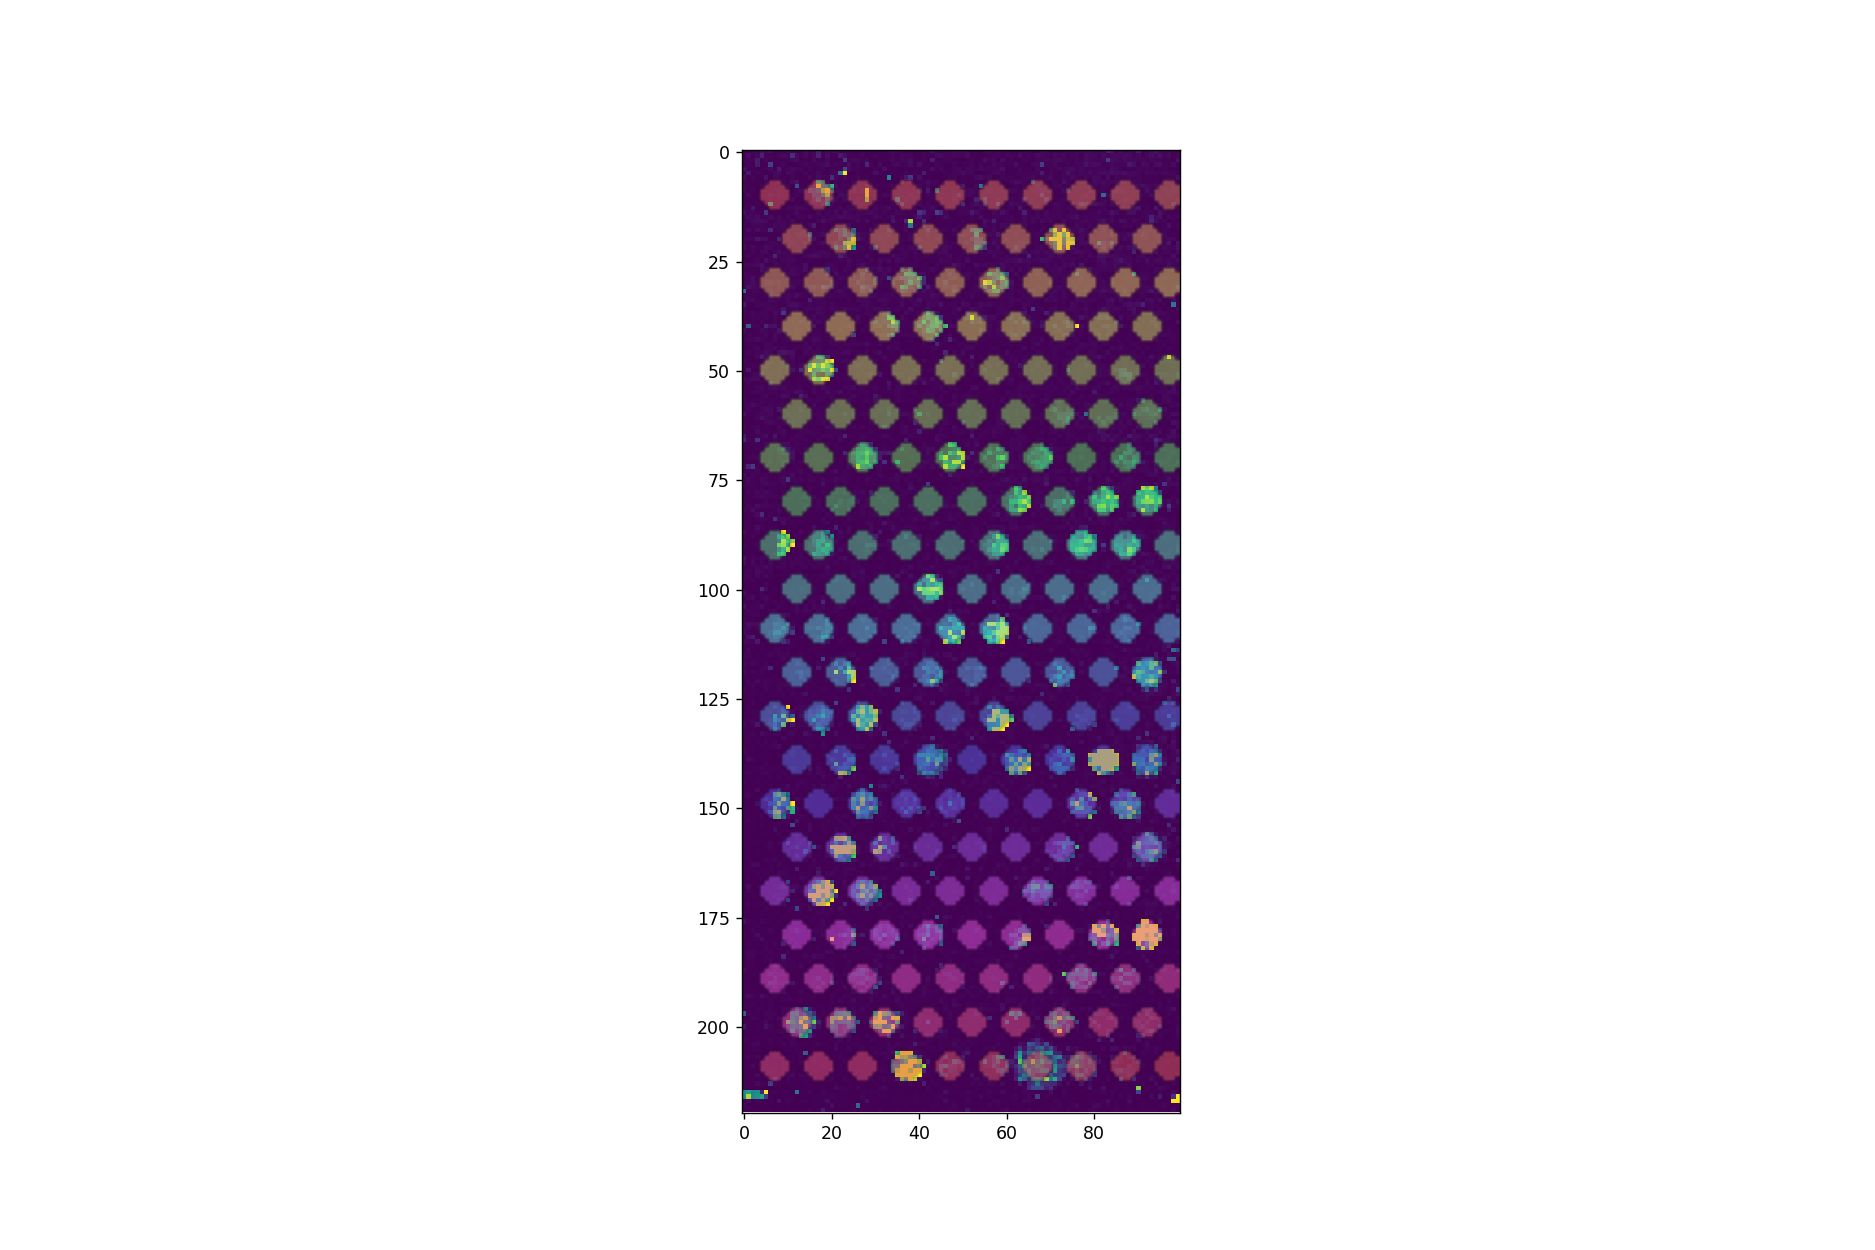

200
(220, 100, 4)


In [10]:
# Load the calibration file
input_grid = json.load(input_grid_file.open('r'))
# Convert it to a mask
grid_mask, mask_names = make_mask(
    h, w,
    input_grid['positions'], 
    input_grid['grid_coords'], 
    input_grid['n_rows'], 
    input_grid['n_cols'], 
    input_grid['spot_h'], 
    input_grid['spot_w'],
    input_grid['alternating_rows'],
)
# Display the mask over the top of the guide image
plt.close('all')
plt.imshow(example_image)
plt.imshow(colorize_mask(grid_mask), interpolation='bilinear')
plt.show()

# When finished calibrating, save the mask for use in analysis steps

In [ ]:
output_mask_file.parent.mkdir(parents=True, exist_ok=True)
np.save(output_mask_file, grid_mask)
output_mask_names_file.parent.mkdir(parents=True, exist_ok=True)
json.dump(mask_names, output_mask_names_file.open('w'))